In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from metpy.units import units
from metpy import calc as mpcalc
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
import math
import netCDF4
from netCDF4 import Dataset
from datetime import datetime, timedelta
from cftime import num2date, date2num
import cartopy.feature
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime as dt

In [2]:
gh_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/data/ECMWF_gh_01252021.nc")
t_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/data/ECMWF_t_01252021.nc")
u_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/data/ECMWF_u_01252021.nc")
v_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/data/ECMWF_v_01252021.nc")
w_ds = xr.open_dataset("/home11/grad/2021/gd673524/research/gdines/data/ECMWF_w_01252021.nc")

In [3]:
u_ds

<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 121, level: 10, number: 10, time: 940)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * level      (level) int32 10 50 100 200 300 500 700 850 925 1000
  * number     (number) int32 1 2 3 4 5 6 7 8 9 10
  * time       (time) datetime64[ns] 2001-01-25 2001-01-26 ... 2020-03-11
Data variables:
    u          (time, number, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-03 00:19:24 GMT by grib_to_netcdf-2.24.0: grib_to_n...

In [4]:
#Creating Variables
lat = gh_ds.latitude
lon = gh_ds.longitude
level = gh_ds.level #<--Levels=[10,50,100,200,300,500,700,850,925,1000]
time = gh_ds.time
number = gh_ds.number

#z_500 = gh.variables['gh'][0,0,5,:,:]
z_1loc = gh_ds.variables['gh'][:,1,5,1,1]
t_1loc = t_ds.variables['t'][:,1,5,1,1]
u_1loc = u_ds.variables['u'][:,1,5,1,1]
v_1loc = v_ds.variables['v'][:,1,5,1,1]
w_1loc = w_ds.variables['w'][:,1,5,1,1]

In [5]:
time

<xarray.DataArray 'time' (time: 940)>
array(['2001-01-25T00:00:00.000000000', '2001-01-26T00:00:00.000000000',
       '2001-01-27T00:00:00.000000000', ..., '2020-03-09T00:00:00.000000000',
       '2020-03-10T00:00:00.000000000', '2020-03-11T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2001-01-25 2001-01-26 ... 2020-03-11
Attributes:
    long_name:  time

In [6]:
# Vertical level specificaton
vlevel = 500
levelStr = str(vlevel)

# Date/Time specification [Data set is every 24-hrs: 2001-01-25 to 2020-03-11]
Year = 2001
Month = 1
Day = 25
Hour = 0
Minute = 0
dateTime = dt(Year,Month,Day, Hour, Minute)
timeStr = dateTime.strftime("%Y-%m-%d %H%M UTC")

In [7]:
timeStr

'2001-01-25 0000 UTC'

In [8]:
#Calculating the Ensemble Means
z_ensmn = gh_ds.mean(dim='number')
t_ensmn = t_ds.mean(dim='number')
u_ensmn = u_ds.mean(dim='number')
v_ensmn = v_ds.mean(dim='number')
w_ensmn = w_ds.mean(dim='number')

In [9]:
t_ensmn

<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 121, level: 10, time: 940)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * level      (level) int32 10 50 100 200 300 500 700 850 925 1000
  * time       (time) datetime64[ns] 2001-01-25 2001-01-26 ... 2020-03-11
Data variables:
    t          (time, level, latitude, longitude) float32 206.3 206.3 ... 250.9

In [10]:
#Creating ensemble 500-hPa mean variables at one location
tens_1loc = t_ensmn.variables['t'][:,5,1,1]
uens_1loc = u_ensmn.variables['u'][:,5,1,1]
vens_1loc = v_ensmn.variables['v'][:,5,1,1]
wens_1loc = w_ensmn.variables['w'][:,5,1,1]
zens_1loc = z_ensmn.variables['gh'][:,5,1,1]

In [11]:
#Calculating total wind average at 1 point
mn_wnd_1loc = (uens_1loc**2 + vens_1loc**2)**(1/2)
#u_ensmn_units = u_ensmn.pint.quantify(units="m/s")
#vens_units = vens_1loc * units('m/s')
#wind_mn_1loc = mpcalc.wind_speed(uens_1loc, vens_1loc)

In [12]:
#Creating 500-hPa Ensemble Mean Vairables at one time
tens_time = t_ensmn.variables['t'][1,5,:,:]
zens_time = z_ensmn.variables['gh'][1,5,:,:]

In [13]:
tens_time

<xarray.Variable (latitude: 121, longitude: 240)>
array([[236.78918, 236.78918, 236.78918, ..., 236.78918, 236.78918,
        236.78918],
       [236.86006, 236.82263, 236.78435, ..., 236.96709, 236.93242,
        236.8971 ],
       [238.17807, 238.08183, 237.98392, ..., 238.45161, 238.3634 ,
        238.27202],
       ...,
       [237.37154, 237.36264, 237.35379, ..., 237.4041 , 237.39204,
        237.38168],
       [236.45413, 236.43826, 236.42326, ..., 236.50491, 236.48758,
        236.47063],
       [236.60136, 236.60136, 236.60136, ..., 236.60136, 236.60136,
        236.60136]], dtype=float32)

<Figure size 1080x864 with 0 Axes>

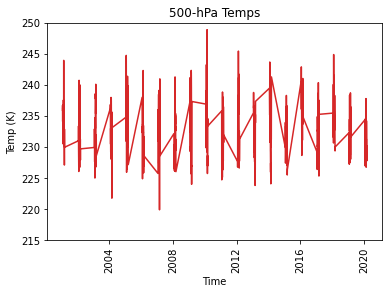

In [14]:
#Time Series plot for 500-hpa Temps for each ensemble at 1 location
fig = plt.figure(figsize=(15,12))
fig, ax = plt.subplots(1, 1)

ax.plot(time, t_1loc, color='tab:red')
ax.set_title('500-hPa Temps')
ax.set_xlabel ('Time')
ax.set_ylabel ('Temp (K)')
ax.set_ylim(215,250)
ax.tick_params(axis='x', labelrotation = 90)

plt.show()

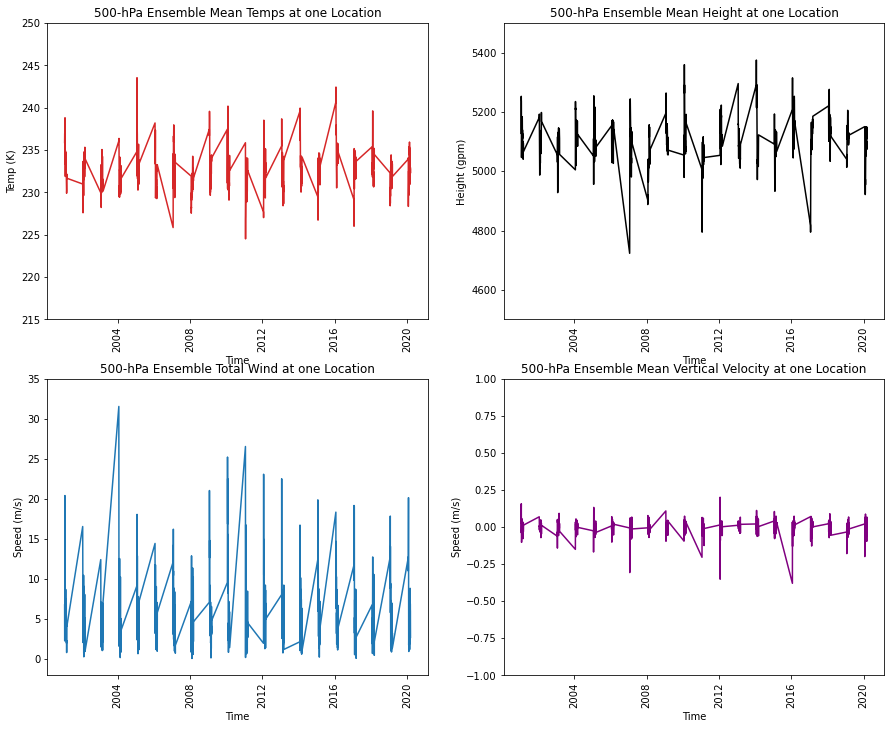

In [15]:
#Making time series plots for the ensemble means at 500-hPa for one location
fig, ((ax, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15,12))

ax.plot(time, tens_1loc, color='tab:red')
ax.set_title('500-hPa Ensemble Mean Temps at one Location')
ax.set_xlabel ('Time')
ax.set_ylabel ('Temp (K)')
ax.set_ylim(215,250)
ax.tick_params(axis='x', labelrotation = 90)

ax2.plot(time, zens_1loc, color='black')
ax2.set_title('500-hPa Ensemble Mean Height at one Location')
ax2.set_xlabel ('Time')
ax2.set_ylabel ('Height (gpm)')
ax2.set_ylim(4500,5500)
ax2.tick_params(axis='x', labelrotation = 90)

ax3.plot(time, mn_wnd_1loc, color='tab:blue')
ax3.set_title('500-hPa Ensemble Total Wind at one Location')
ax3.set_xlabel ('Time')
ax3.set_ylabel ('Speed (m/s)')
ax3.set_ylim(-2,35)
ax3.tick_params(axis='x', labelrotation = 90)

ax4.plot(time, wens_1loc, color='purple')
ax4.set_title('500-hPa Ensemble Mean Vertical Velocity at one Location')
ax4.set_xlabel ('Time')
ax4.set_ylabel ('Speed (m/s)')
ax4.set_ylim(-1,1)
ax4.tick_params(axis='x', labelrotation = 90)

plt.show()
fig.tight_layout()

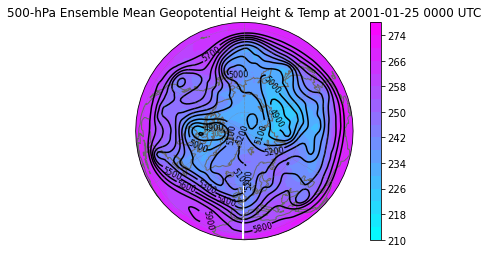

In [18]:
# Areal extent
plt.Figure(figsize=(16,16),dpi=120)    ## <---Set fig size here!

#Set plot as an orthographic projection looking down at the Earth from the pole with 0˚ at 6-oclock
ax = plt.axes(projection=ccrs.Orthographic(0,90))     
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='dimgray',facecolor='none')
#ax.outline_patch.set_edgecolor('none')
gl = ax.gridlines(color="grey",linestyle=":",linewidth=0.5)  
glevs = range(4000,6000,100)  ## <---set contour interval for geo. heights
tlevs = range(210,280,4)        ## <--- set contour interval for temp
[x,y] = np.meshgrid(lon,lat)  ## <--- set lat/lon as coords on grid
        
plt.title(f"500-hPa Ensemble Mean Geopotential Height & Temp at {timeStr}")
hghtplot = ax.contour(x,y,zens_time,glevs,transform=ccrs.PlateCarree(),extend='both',colors='black', linewidth=1)
ax.clabel(hghtplot, inline=True, fmt="%.0f", fontsize=8)
tempplot = ax.contourf(x,y,tens_time,tlevs,transform=ccrs.PlateCarree(),cmap="cool")
plt.colorbar(tempplot)

plt.show()